**Задача:** сможет ли пользователь успешно закончить онлайн курс
Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:

**submission_data_test.csv**

**events_data_test.csv** 

хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019.

Используя данные о первых двух днях активности на курсе  нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. 

Признаки в файлах: 



**events_data_test.csv** - данные о действиях, которые совершают студенты со стэпами

1.   **step_id** - id стэпа
2.   **user_id** - анонимизированный id юзера
3.   **timestamp** - время наступления события в формате unix date
4. **action** - событие, возможные значения:











*   **discovered** - пользователь перешел на стэп
*   **viewed** - просмотр шага,
*   **started_attempt** - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
*   **passed** - удачное решение практического шага


**submissions_train.csv** - данные о времени и статусах сабмитов к практическим заданиям


1.   **step_id** - id стэпа
2.   **timestamp** - время отправки решения в формате unix date
3.  ** submission_status** - статус решения
4.   **user_id** - анонимизированный id юзера






In [2]:
import pandas as pd
import numpy as np

get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_PERIOD_DAYS = 2  # колво дней по которым доступны данные для прогноза

In [4]:
def get_x_y(events, submissions):
  
    """" создадим признаки и метку
     
    Parameters
    ----------
    events: pandas.DataFrame
        действия студентов со степами
    submissions: pandas.DataFrame
        действия студентов по практике     
     """
    events_train = preprocess_timestamp_cols(events)
    events_train = truncate_data_by_nday(events_train, DATA_PERIOD_DAYS)

    submissions_train = preprocess_timestamp_cols(submissions)
    submissions_train = truncate_data_by_nday(submissions_train, DATA_PERIOD_DAYS)

    X = create_user_data(events_train, submissions_train)
    X = X.set_index('user_id')
    
#     safe_drop_cols_df(X, ['last_timestamp'])
    X = X.drop('last_timestamp', axis='columns')

    y = get_y(events, submissions)

    # после создания признаков и метки порядок следования user_id может не совпадать
    X = X.sort_index()
    y = y.sort_index()
    assert X.shape[0] == y.shape[0]
    
    return X, y

def preprocess_timestamp_cols(data):
  
    """ 
    Parameters
    ----------
    data : pd.DataFrame
        данные с действиями пользователя
    """
    data['date'] = pd.to_datetime(data.timestamp, unit='s')
    data['day'] = data.date.dt.date
    return data

def truncate_data_by_nday(data, n_day):
  
    """ Взять события из n_day первых дней по каждому пользователю 
        Parameters
        ----------
        data: pandas.DataFrame
            действия студентов со степами или практикой
        n_day : int
            размер тестовой выборки
    """
    
    users_min_time = data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(
        {'timestamp': 'min_timestamp'}, axis=1)
    users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day

    events_data_d = pd.merge(data, users_min_time, how='inner', on='user_id')
    cond = events_data_d['timestamp'] <= events_data_d['min_timestamp']
    events_data_d = events_data_d[cond]

    assert events_data_d.user_id.nunique() == data.user_id.nunique()
    
    return events_data_d.drop(['min_timestamp'], axis=1)

def create_user_data(events, submissions):
  
    """ создать таблицу с данными по каждому пользователю
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    """
    users_data = events.groupby('user_id', as_index=False)         .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

    # попытки сдачи практики пользователя
    users_scores = submissions.pivot_table(index='user_id',
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
    users_data = users_data.merge(users_scores, on='user_id', how='outer')
    users_data = users_data.fillna(0)

    # колво разных событий пользователя по урокам
    users_events_data = events.pivot_table(index='user_id',
                                           columns='action',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
    users_data = users_data.merge(users_events_data, how='outer')

    # колво дней на курсе
    users_days = events.groupby('user_id').day.nunique().to_frame().reset_index()
    users_data = users_data.merge(users_days, how='outer')

    return users_data

def create_interaction(events, submissions):
  
    """ объединить все данные по взаимодействию
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    """
    interact_train = pd.concat([events, submissions.rename(columns={'submission_status': 'action'})])
    interact_train.action = pd.Categorical(interact_train.action,
                                           ['discovered', 'viewed', 'started_attempt',
                                            'wrong', 'passed', 'correct'], ordered=True)
    interact_train = interact_train.sort_values(['user_id', 'timestamp', 'action'])
    
    return interact_train


def get_y(events, submissions, course_threshold=40, target_action='passed'):
  
    """ создать метку  (целевая переменная для прогноза is_gone
    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователя
    submissions : pd.DataFrame
        данные самбитов практики
    course_threshold : int
        порог в колве заданий, когда курс считается пройденным
    target_action: string
        название действия по степу, по колву которых мы рассчитываем целевую переменную 
    """
    interactions = create_interaction(events, submissions)
    users_data = interactions[['user_id']].drop_duplicates()

    assert target_action in interactions.action.unique()
    passed_steps = (interactions.query("action == @target_action")
                    .groupby('user_id', as_index=False)['step_id'].count()
                    .rename(columns={'step_id': target_action}))
    users_data = users_data.merge(passed_steps, how='outer')

    # пройден ли курс
    users_data['is_gone'] = users_data[target_action] > course_threshold
    assert users_data.user_id.nunique() == events.user_id.nunique()
    users_data = (users_data.drop(target_action, axis=1)
                  .set_index('user_id'))
    
    return users_data['is_gone']

def split_events_submissions(events, submissions, test_size=0.3):
  
    """ разделение выборки на трейн и тест по пользователям
        Parameters
        ----------
        events: pandas.DataFrame
            действия студентов со степами
        submissions: pandas.DataFrame
            действия студентов по практике     
        test_size : float
            размер тестовой выборки
     """

    # сделаем случайную выборку пользователей курса для теста
    users_ids = np.unique(np.concatenate((events.user_id.unique(), submissions.user_id.unique())))
    np.random.shuffle(users_ids)
    test_sz = int(len(users_ids) * test_size)
    train_sz = len(users_ids) - test_sz
    train_users = users_ids[:train_sz]
    test_users = users_ids[-test_sz:]
    # Проверка что пользователи не пересекаются
    assert len(np.intersect1d(train_users, test_users)) == 0

    # теперь делим данные
    event_train = events[events.user_id.isin(train_users)]
    event_test = events[events.user_id.isin(test_users)]
    submissions_train = submissions[submissions.user_id.isin(train_users)]
    submissions_test = submissions[submissions.user_id.isin(test_users)]

    return event_train, event_test, submissions_train, submissions_test


def create_dataset(events_data, submissions_data):

  DEBUG = True
  
  if DEBUG:
    print('events_data: ', events_data.shape)
    print('submissions_data: ', submissions_data.shape)  

  user_learning_time_treshold = 2 * 24 * 60 * 60
  
  events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
  events_data['day'] = events_data.date.dt.date

  submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
  submissions_data['day'] = submissions_data.date.dt.date
  
  users_course_result = events_data[events_data.action == 'passed'][['step_id', 'user_id']]                              .drop_duplicates()                             .groupby(['user_id'])                             .agg({'step_id' : 'count'})                             .rename({'step_id' : 'steps_passed'}, axis='columns')                             .reset_index()
  
  if DEBUG: print('users_course_result: ', users_course_result.shape)
  

  users_course_result['passed_course'] = users_course_result.steps_passed > 40
  users_course_result['passed_course'] = users_course_result['passed_course'].map(int)
  users_course_result = users_course_result.drop('steps_passed', axis='columns')
  
  user_start_time = events_data.groupby('user_id', as_index=False)         .agg({'timestamp': 'min'})         .rename({'timestamp': 'start_course_timestamp'}, axis=1)    

  if DEBUG: print('user_start_time: ', user_start_time.shape)
    
  user_last_visit_time = events_data.groupby('user_id', as_index=False)         .agg({'timestamp': 'max'})         .rename({'timestamp': 'last_visit_time'}, axis=1)    
  
  if DEBUG: print('user_last_visit_time: ', user_last_visit_time.shape)
  
  events_data = events_data.merge(user_start_time, on='user_id', how='outer')
  events_data = events_data[events_data.timestamp <= events_data.start_course_timestamp + user_learning_time_treshold]
  events_data.drop('start_course_timestamp', axis=1)
    
  if DEBUG: print('events_data after triming: ', user_start_time.shape)
 
  unique_days_in_events_data = events_data.groupby('user_id').day.nunique().max()
  
  if DEBUG: print('unique_days_in_events_data: ', unique_days_in_events_data)
  
  submissions_data = submissions_data.merge(user_start_time, on='user_id', how='outer')
  submissions_data = submissions_data[submissions_data.timestamp <= submissions_data.start_course_timestamp + user_learning_time_treshold]
  submissions_data.drop('start_course_timestamp', axis=1)  
      
  if DEBUG: print('submissions_data after triming: ', user_start_time.shape)
 
  unique_days_in_submissions_data = submissions_data.groupby('user_id').day.nunique().max()
  
  if DEBUG: print('unique_days_in_submissions_data: ', unique_days_in_submissions_data)
  
  users_scores = submissions_data.pivot_table(index='user_id',
                          columns='submission_status',
                          values='step_id',
                          aggfunc='count',
                          fill_value=0).reset_index()

  if DEBUG: print('users_scores: ', users_scores.shape)

  steps_tried = submissions_data.groupby('user_id').step_id         .nunique().to_frame().reset_index().rename(columns={
            'step_id': 'steps_tried'})
  
  if DEBUG: print('steps_tried: ', steps_tried.shape)

  users_actions = events_data.pivot_table(index='user_id',
                            columns='action',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()  
  
  if DEBUG: print('users_actions: ', users_actions.shape)

  users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
  
  if DEBUG: print('users_days: ', users_days.shape)
    
  X = users_days
    
 

  X = X.merge(users_actions, on='user_id', how='outer')  

  X = X.merge(users_scores, on='user_id', how='outer')  



  X = X.merge(users_course_result, on='user_id', how='outer')  


  X = X.fillna(0)

  X = X.set_index('user_id')

  y = X.passed_course
  X = X.drop('passed_course', axis='columns')

  if DEBUG:
    print('X: ', X.shape)
    print('y: ', y.shape)

  return X, y

def model_assessment(estimator, X, y, set_label):
  
  print(set_label, ' score:', estimator.score(X, y))
  print(set_label, ' roc_auc:', metrics.roc_auc_score(y, estimator.predict(X)))

  cv_scores = cross_val_score(estimator, X, y, scoring='roc_auc', cv=3, n_jobs=-1)
  mean_cv_scores = np.mean(cv_scores)
  print (set_label, ' cross_val mean score:', mean_cv_scores)
  print('\n')
  
  predict_proba = estimator.predict_proba(X)
  print(pd.cut(predict_proba[:,1], 10).value_counts())
  print('\n')

  pd.Series(predict_proba[:,1]).hist()

  fpr, tpr, thresholds = metrics.roc_curve(y, predict_proba[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  print(roc_auc)
  print('\n')

  plt.figure()
  plt.plot(fpr, tpr, label = 'Area = %0.2f' % (roc_auc))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0, 1])
  plt.ylim([0, 1.05])

  predict_y = estimator.predict(X)
  print(metrics.confusion_matrix(y, predict_y))
  print('\n')  

In [6]:
events_data_train = pd.read_csv('/content/sample_data/event_data_train (1).zip', compression='zip')
# events_data_train = pd.read_csv('event_data_train.zip', compression='zip')
events_data_train.shape

print('events_data_train shape', events_data_train.shape)

submissions_data_train = pd.read_csv('/content/sample_data/submissions_data_train (1).zip', compression='zip')
# submissions_data_train = pd.read_csv('submissions_data_train.zip', compression='zip')
submissions_data_train.shape

print('submissions_data_train shape', submissions_data_train.shape)

events_data_train shape (3480703, 4)
submissions_data_train shape (509104, 4)


In [7]:
control_events_data = pd.read_csv('/content/sample_data/events_data_test.csv')
control_events_data.shape

print('control_events_data shape', control_events_data.shape)

control_submissions_data = pd.read_csv('/content/sample_data/submission_data_test.csv')
control_submissions_data.shape

print('control_submissions_data shape', control_submissions_data.shape)


control_events_data shape (274768, 4)
control_submissions_data shape (42261, 4)


In [8]:
X, y = create_dataset(events_data_train, submissions_data_train)

events_data:  (3480703, 4)
submissions_data:  (509104, 4)
users_course_result:  (17262, 2)
user_start_time:  (19234, 2)
user_last_visit_time:  (19234, 2)
events_data after triming:  (19234, 2)
unique_days_in_events_data:  3
submissions_data after triming:  (19234, 2)
unique_days_in_submissions_data:  3
users_scores:  (8815, 3)
steps_tried:  (8815, 2)
users_actions:  (19234, 5)
users_days:  (19234, 2)
X:  (19234, 7)
y:  (19234,)


In [9]:
X.head()

,day,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,,
1,1,1,0,0,1,0.0,0.0
2,1,9,9,2,9,2.0,0.0
3,1,15,15,4,20,4.0,4.0
5,1,1,1,0,1,0.0,0.0
7,1,1,1,0,1,0.0,0.0


In [10]:
y.value_counts()

0.0    14596
1.0     4638
Name: passed_course, dtype: int64

In [11]:
eug_X, eug_y = get_x_y(events_data_train, submissions_data_train)

In [12]:
eug_X.head()

,correct,wrong,discovered,passed,started_attempt,viewed,day
user_id,,,,,,,
1,0.0,0.0,1,0,0,1,1
2,2.0,0.0,9,9,2,9,1
3,4.0,4.0,15,15,4,20,1
5,2.0,2.0,1,1,0,1,1
7,0.0,0.0,1,1,0,1,1


In [13]:
eug_y.value_counts()

False    14596
True      4638
Name: is_gone, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.61)

In [15]:
event_train, event_test, submissions_train, submissions_test = split_events_submissions(events_data_train, submissions_data_train)

X_train, y_train = create_dataset(event_train, submissions_train)
X_test, y_test   = create_dataset(event_test, submissions_test)

events_data:  (2404741, 6)
submissions_data:  (356395, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

users_course_result:  (12072, 2)
user_start_time:  (13464, 2)
user_last_visit_time:  (13464, 2)
events_data after triming:  (13464, 2)
unique_days_in_events_data:  3
submissions_data after triming:  (13464, 2)
unique_days_in_submissions_data:  3
users_scores:  (6183, 3)
steps_tried:  (6183, 2)
users_actions:  (13464, 5)
users_days:  (13464, 2)
X:  (13464, 7)
y:  (13464,)
events_data:  (1075962, 6)
submissions_data:  (152709, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

users_course_result:  (5190, 2)
user_start_time:  (5770, 2)
user_last_visit_time:  (5770, 2)
events_data after triming:  (5770, 2)
unique_days_in_events_data:  3
submissions_data after triming:  (5770, 2)
unique_days_in_submissions_data:  3
users_scores:  (2632, 3)
steps_tried:  (2632, 2)
users_actions:  (5770, 5)
users_days:  (5770, 2)
X:  (5770, 7)
y:  (5770,)


In [16]:
X_train.shape

(13464, 7)

In [17]:
X_train.head()

,day,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,,
1,1,1,0,0,1,0.0,0.0
14,1,4,3,1,9,0.0,1.0
16,2,50,49,21,117,18.0,23.0
17,1,6,5,1,13,0.0,2.0
18,1,3,2,0,3,0.0,0.0


In [18]:
y_train.value_counts()

0.0    10222
1.0     3242
Name: passed_course, dtype: int64

In [19]:
control_X, control_y = create_dataset(control_events_data, control_submissions_data)

events_data:  (274768, 4)
submissions_data:  (42261, 4)
users_course_result:  (5551, 2)
user_start_time:  (6184, 2)
user_last_visit_time:  (6184, 2)
events_data after triming:  (6184, 2)
unique_days_in_events_data:  3
submissions_data after triming:  (6184, 2)
unique_days_in_submissions_data:  3
users_scores:  (2398, 3)
steps_tried:  (2398, 2)
users_actions:  (6184, 5)
users_days:  (6184, 2)
X:  (6184, 7)
y:  (6184,)


(20.87, 34.0]     529
(34.0, 47.0]      255
(47.0, 60.0]      105
(60.0, 73.0]       80
(86.0, 99.0]       32
(73.0, 86.0]       25
(99.0, 112.0]      13
(112.0, 125.0]      3
(125.0, 138.0]      2
(138.0, 151.0]      1
Name: passed, dtype: int64


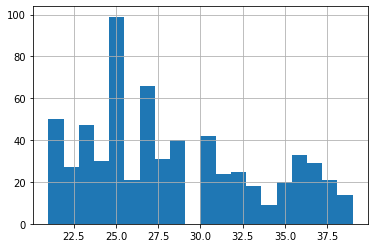

In [20]:
print(pd.cut(control_X.passed[control_X.passed > 20], 10).value_counts())
control_X[(control_X.passed > 20) & (control_X.passed < 40)].passed.hist(bins  = 20)

In [21]:
control_y.value_counts()

0.0    5816
1.0     368
Name: passed_course, dtype: int64

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [23]:
estimator = RandomForestClassifier()

#params = {'n_estimators':range(1, 101), 'max_depth' : range(1, 20), 'min_samples_leaf' :[10], 'min_samples_split' : range(20, 100, 10), 'class_weight':['balanced','balanced_subsample']}
# params = {'n_estimators':range(1, 101), 'min_samples_leaf' :[10], 'min_samples_split' : range(20, 50, 10), 'class_weight':['balanced','balanced_subsample']}

params = {'n_estimators':[100], 'min_samples_leaf' :[10], 'min_samples_split' : [10], 'class_weight':['balanced','balanced_subsample']}

# estimator = xgb.XGBClassifier()
# params = {'n_estimators' : range(1, 51), 'learning_rate': np.arange(0.1, 0.6, 0.1), 'max_depth' : range(1,11) , 'min_child_weight': range(2, 11)}
# params = {'n_estimators' :[45] , 'learning_rate': [0.3], 'max_depth' : range(1,11) , 'min_child_weight': range(2, 11)}

searcher = GridSearchCV(estimator = estimator, param_grid=params, cv=3, scoring='roc_auc')

get_ipython().magic(u'time searcher.fit(X_train, y_train)')

best_estimator =  searcher.best_estimator_

scorer = searcher.scorer_
print(scorer)

best_params = searcher.best_params_
print(best_params)

# best_estimator = RandomForestClassifier(n_estimators=100, n_jobs=2, 
#                             min_samples_leaf=10, min_samples_split=10, 
#                             class_weight='balanced')

# best_estimator.fit(X_train, y_train)



CPU times: user 4.97 s, sys: 4.75 ms, total: 4.97 s
Wall time: 4.97 s
make_scorer(roc_auc_score, needs_threshold=True)
{'class_weight': 'balanced_subsample', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [24]:
fimp = pd.DataFrame([best_estimator.feature_importances_], columns=X_train.columns).T
fimp.columns = ['weight']
fimp.sort_values(by='weight', ascending=False)

,weight
passed,0.287768
discovered,0.198695
viewed,0.177122
correct,0.174789
started_attempt,0.095832
wrong,0.038775
day,0.027020


In [25]:
prdict_proba_train = best_estimator.predict_proba(X_train)
print(prdict_proba_train)

prdict_proba_train[np.where(y_train == 1), 1] = 1
print(prdict_proba_train)

fpr, tpr, thresholds = metrics.roc_curve(y_train, prdict_proba_train[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
print('\n')

metrics.roc_auc_score(y_train, best_estimator.predict(X_train))

[[9.80397540e-01 1.96024604e-02]
 [9.07761916e-01 9.22380842e-02]
 [7.12956523e-04 9.99287043e-01]
 ...
 [9.88357189e-01 1.16428114e-02]
 [4.61761595e-01 5.38238405e-01]
 [6.88628510e-01 3.11371490e-01]]
[[9.80397540e-01 1.96024604e-02]
 [9.07761916e-01 9.22380842e-02]
 [7.12956523e-04 1.00000000e+00]
 ...
 [9.88357189e-01 1.16428114e-02]
 [4.61761595e-01 5.38238405e-01]
 [6.88628510e-01 3.11371490e-01]]
1.0




0.81586207537516

X_train  score: 0.8254604872251932
X_train  roc_auc: 0.81586207537516
X_train  cross_val mean score: 0.8770528548410842


(0.00551, 0.106]    1751
(0.106, 0.205]      4313
(0.205, 0.305]      1146
(0.305, 0.404]       893
(0.404, 0.503]      1099
(0.503, 0.603]      1195
(0.603, 0.702]       715
(0.702, 0.801]       601
(0.801, 0.901]       575
(0.901, 1.0]        1176
dtype: int64


0.9020132454935353


[[8529 1693]
 [ 657 2585]]




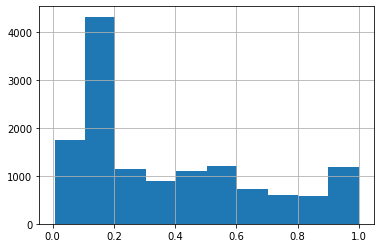

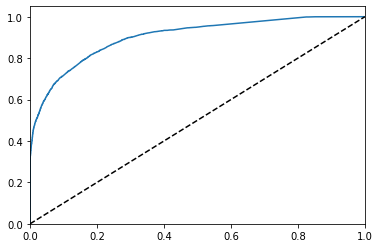

In [26]:
model_assessment(best_estimator, X_train, y_train, 'X_train')

In [27]:
X_train.shape

(13464, 7)

X_test  score: 0.8045060658578856
X_test  roc_auc: 0.7854633658385117
X_test  cross_val mean score: 0.8684971100400435


(0.00551, 0.106]     762
(0.106, 0.205]      1871
(0.205, 0.305]       450
(0.305, 0.404]       403
(0.404, 0.503]       469
(0.503, 0.603]       539
(0.603, 0.702]       308
(0.702, 0.801]       239
(0.801, 0.901]       258
(0.901, 1.0]         471
dtype: int64


0.8706923432683098


[[3597  777]
 [ 351 1045]]




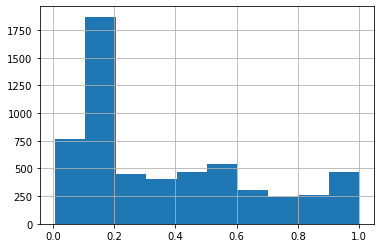

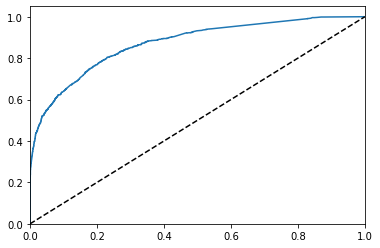

In [28]:
model_assessment(best_estimator, X_test, y_test, 'X_test')

In [29]:
X_test.shape

(5770, 7)

control_X  score: 0.8040103492884865
control_X  roc_auc: 0.8958046767537826
control_X  cross_val mean score: 1.0


(0.00896, 0.109]     713
(0.109, 0.208]      2725
(0.208, 0.307]       404
(0.307, 0.406]       357
(0.406, 0.505]       412
(0.505, 0.604]       416
(0.604, 0.703]       217
(0.703, 0.802]       227
(0.802, 0.901]       222
(0.901, 1.0]         491
dtype: int64


0.9991664673165481


[[4604 1212]
 [   0  368]]




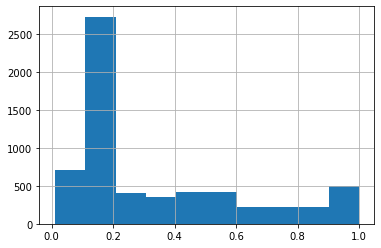

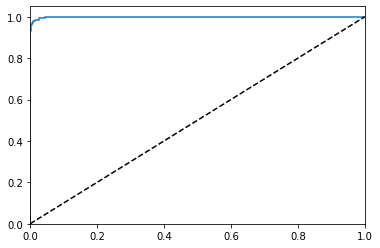

In [30]:
model_assessment(best_estimator, control_X, control_y, 'control_X')

In [31]:
control_X.shape

(6184, 7)

In [32]:
result_X = control_X.copy()
result_y = control_y.copy()

In [33]:
result_predict_proba = best_estimator.predict_proba(result_X)
# result_predict_proba[np.where(result_y == 1), 1] = 1


In [35]:
result_X['is_gone'] = pd.Series(result_predict_proba[:,1], index=result_X.index)
             
#result_X.loc[:,is_gone'] = pd.Series(result_predict_proba[:,1], index=result_X.index)

# result_X['is_gone'] = np.where(result_X['passed'] >= 40, 1, result_X['passed'] / 40)
# result_X['is_gone'] = np.where(result_X['passed'] < 13, 0, result_X['is_gone'])

In [36]:
result_X[result_X.is_gone > 0]

,day,discovered,passed,started_attempt,viewed,correct,wrong,is_gone
user_id,,,,,,,,
4,1,1,1,0,1,0.0,0.0,0.125463
6,1,1,1,0,1,0.0,0.0,0.125463
10,1,2,2,0,6,0.0,0.0,0.380796
12,1,11,9,4,14,1.0,0.0,0.391316
13,2,70,70,35,105,29.0,36.0,1.000000
...,...,...,...,...,...,...,...,...
26791,1,1,1,0,1,0.0,0.0,0.125463
26795,1,1,1,0,1,0.0,0.0,0.125463
26796,1,6,4,2,12,0.0,0.0,0.375063


In [37]:
pd.cut(result_X.is_gone, 10).value_counts()

(0.109, 0.208]      2725
(0.00896, 0.109]     713
(0.901, 1.0]         491
(0.505, 0.604]       416
(0.406, 0.505]       412
(0.208, 0.307]       404
(0.307, 0.406]       357
(0.703, 0.802]       227
(0.802, 0.901]       222
(0.604, 0.703]       217
Name: is_gone, dtype: int64

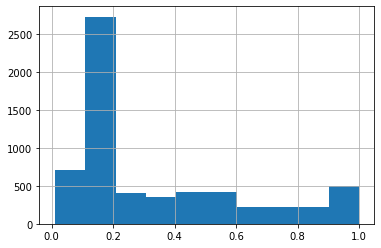

In [38]:
result_X.is_gone.hist()

In [39]:
user_success_probability = result_X[['is_gone']]

In [40]:
user_success_probability.shape

(6184, 1)

In [41]:
user_success_probability.head()

,is_gone
user_id,
4,0.125463
6,0.125463
10,0.380796
12,0.391316
13,1.000000


In [ ]:
user_success_probability.to_csv('C/content/user_success_probability.csv')